### Modeling and visualizing dynamics of COVID cases in Maryland counties
#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-04-12


In [10]:
# import latest MD county counts
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_county_covid.csv'
md_county=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)

In [11]:
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_covid_H.csv'
md_xtra=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)

In [12]:
md_county.tail()

,Date,Allegany,Anne Arundel,Baltimore City,Baltimore County,Calvert,Caroline,Carroll,Cecil,Charles,...,Montgomery,Prince Georges,Queen Anne's,St. Mary's,Somerset,Talbot,Washington,Wicomico,Worcester,Total
Date_index,,,,,,,,,,,,,,,,,,,,,
33,2020-04-07,7,370,459,652,41,11,159,41,136,...,871,1020,15,46,4,8,44,17,10,4371
34,2020-04-08,6,466,571,866,56,11,186,49,164,...,1088,1310,16,62,4,10,57,20,10,5529
35,2020-04-09,8,505,638,979,66,12,203,54,180,...,1214,1476,17,65,4,13,60,21,16,6185
36,2020-04-10,10,554,689,1072,76,12,214,64,220,...,1388,1716,17,71,4,13,66,28,16,6968
37,2020-04-11,11,615,756,1173,82,15,214,66,235,...,1537,1923,19,73,4,13,72,33,19,7694


In [13]:
# create exponential function to model 
# will add additional functions shortly

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    return a*x + b

In [14]:
def SSE_curve(x,y,fxn):
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

In [15]:
# date range of the graph
start_date = min(md_county['Date'])
end_date = max(md_county['Date'])
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-05 to 2020-04-11


In [16]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')
next2_label = (end_date + datetime.timedelta(days=2)).strftime('%m/%d')
next3_label = (end_date + datetime.timedelta(days=3)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)


# output date range as list
dates = [date.strftime('%m/%d') for date in date_range_plus]

In [17]:
# model fit for hosp
model_hosp = pd.DataFrame(index=['hosp'],columns=['a','b','c','model'])
model_hosp.fillna(0)

xdata=np.array(md_xtra.index)[17:]
ydata=np.array(md_xtra["Hospitalized"])[17:]
popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)

min_error=min(SSE_exp,SSE_quad,SSE_lin)
    
if min_error == SSE_exp:
    model_hosp.loc['hosp',['a','b','c']]=popt_exp
    model_hosp.loc['hosp','model']='exp'
elif min_error == SSE_quad:
    model_hosp.loc['hosp',['a','b','c']]=popt_quad
    model_hosp.loc['hosp','model']='quad'
elif min_error == SSE_lin:
    model_hosp.loc['hosp',['a','b']]=popt_lin
    model_hosp.loc['hosp','model']='lin'

In [18]:
model_hosp

,a,b,c,model
hosp,2.87771,-72.1473,365.407,quad


In [19]:
# model fit for select counties
counties_to_model=['Montgomery','Anne Arundel',"Prince Georges","Howard",'Baltimore City','Baltimore County','Total']
model_results=pd.DataFrame(index=counties_to_model,columns=['a','b','c','model'])
model_results.fillna(0)

xdata=np.array(md_county.index)[-10:]
for county in counties_to_model:
    ydata=np.array(md_county[county])[-10:]
    
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    try:
        popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
        min_error=min(SSE_exp,SSE_quad,SSE_lin)
    except:    
        min_error=min(SSE_quad,SSE_lin)
    
    
    
    
    if min_error == SSE_exp:
        model_results.loc[county,['a','b','c']]=popt_exp
        model_results.loc[county,'model']='exp'
    elif min_error == SSE_quad:
        model_results.loc[county,['a','b','c']]=popt_quad
        model_results.loc[county,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'

In [20]:
model_results

,a,b,c,model
Montgomery,8.57955,-441.077,6130.86,quad
Anne Arundel,25.3496,0.0906564,-107.48,exp
Prince Georges,10.5152,-520.364,6801.94,quad
Howard,1.09848,-48.953,660.636,quad
Baltimore City,2.56818,-111.895,1389.07,quad
Baltimore County,4.22727,-182.852,2167.84,quad
Total,34.9015,-1667.85,21714.1,quad


In [21]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates)))
xdata_pred=np.array(range(len(dates)))[-11:]
xdata_hosp=np.array(range(len(dates)))[-11:]

In [22]:
#func use
def function_use(county,model_results):
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'Exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'Quadratic'
    else:
        func_use=lin_func
        opt_model = 'Linear'
    return func_use, opt_model

In [23]:
# hospitalization/positive case ratio
h_p=pd.DataFrame(md_xtra.loc[21:]["Hospitalized"]/md_county.loc[21:]["Total"])
h_p.columns=["Percent"]
h_p["Percent"] = [float("{:.3f}".format(100*item)) for item in h_p["Percent"]]
h_p

,Percent
Date_index,
21,22.759
22,22.351
23,22.782
24,22.357
25,24.982
26,25.843
27,26.297
28,24.968
29,24.075


In [24]:
# hospitalization/positive case ratio
h_d=pd.DataFrame(md_xtra.loc[23:]["Deaths"]/md_county.loc[23:]["Total"])
h_d.columns=["Percent"]
h_d["Percent"] = [float("{:.3f}".format(100*item)) for item in h_d["Percent"]]
h_d

,Percent
Date_index,
23,0.504
24,0.807
25,1.062
26,1.084
27,1.562
28,1.544
29,1.523
30,1.696
31,1.856


### Maryland model and dynamics

In [25]:
next_day = xdata_pred[-1]
next2_day = next_day+1; next3_day = next_day+2
sub = "[1] First cases in Maryland; [2] Bars, restaurants, gyms close; [3] Non-essential businesses close; [4] Stay-at-home order"

In [26]:
popt_state = model_results.loc["Total"][0:3]
func_use, opt_model = function_use("Total",model_results)

popt_hosp = model_hosp.loc["hosp"][0:3]
func_use_hosp, opt_model_hosp = function_use("hosp",model_hosp)

next_day_cases = func_use(next_day, popt_state[0], popt_state[1], popt_state[2])
next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1], popt_state[2])
next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1], popt_state[2])

next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])

loc = "Maryland cases"
locH = "Maryland hospitalizations"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


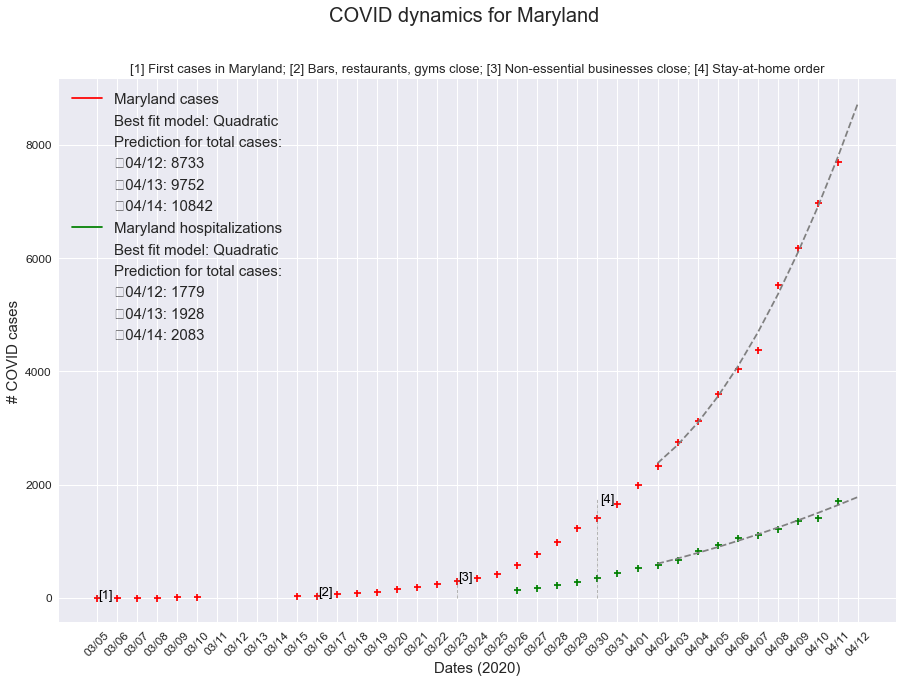

In [27]:
legend_elements =  [Line2D([0], [0], marker='+', color='red', label=loc, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases)), markersize=15),
                    Line2D([0], [0], marker='+', color='green', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model_hosp), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases_hosp)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases_hosp)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases_hosp)), markersize=15)]

plt.figure(figsize=(15,10))

plt.plot(xdata_pred, func_use(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(md_county.index,md_county['Total'],color='red',marker='+');

plt.plot(xdata_hosp, func_use_hosp(xdata_hosp, *popt_hosp), color='grey',linestyle='--');
plt.scatter(md_xtra.index[17:],md_xtra['Hospitalized'][17:],color='green',marker='+');

plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,40,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=100,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,90,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=370,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,360,"[3]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=1750,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.5,1740,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Maryland",fontsize=20);
plt.title(sub, fontsize=13);

In [ ]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Crude CFR (Case Fatality Rate) for Maryland',fontsize=17)

ax = fig.add_subplot(221)
legend_elements =  [Line2D([0], [0], marker='+', color='seagreen', label="%(Hospitalizations/positive cases)", markersize=15)]
plt.plot(h_p.index,h_p["Percent"],'o-',color='seagreen');  
plt.ylabel('% Hospitalizations/positive cases',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

ax = fig.add_subplot(222)
legend_elements =  [Line2D([0], [0], marker='+', color='mediumorchid', label="% Crude CFR", markersize=15)]
plt.plot(h_d.index,h_d["Percent"],'o-',color='mediumorchid');   
plt.ylabel('% Crude CFR',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

plt.show()
        

### Dynamics for two counties: Montgomery and Prince George's

In [ ]:
poptM = model_results.loc["Montgomery"][0:3]
poptP = model_results.loc["Prince Georges"][0:3]

func_useM, opt_modelM = function_use("Montgomery",model_results)
func_useP, opt_modelP = function_use("Prince Georges",model_results)

next_day_casesM = func_useM(next_day, poptM[0], poptM[1], poptM[2])
next2_day_casesM = func_useM(next2_day, poptM[0], poptM[1], poptM[2])
next3_day_casesM = func_useM(next3_day, poptM[0], poptM[1], poptM[2])

next_day_casesP = func_useP(next_day, poptP[0], poptP[1], poptP[2])
next2_day_casesP = func_useP(next2_day, poptP[0], poptP[1], poptP[2])
next3_day_casesP = func_useP(next3_day, poptP[0], poptP[1], poptP[2])

locM = "Montgomery County"
locP = "Prince George's County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

In [ ]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locM, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelM), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesM)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locP, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelP), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesP)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesP)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesP)), markersize=15)]

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useM(xdata_pred, *poptM), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Montgomery'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useP(xdata_pred, *poptP), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Prince Georges'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,45,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=70,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,65,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=125,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,120,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=400,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,395,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Maryland counties: Montgomery and Prince George's",fontsize=20); 
plt.title(sub, fontsize=13);

### Dynamics for two counties: Howard and Anne Arundel

In [ ]:
poptH = model_results.loc["Howard"][0:3]
poptA = model_results.loc["Anne Arundel"][0:3]

func_useH, opt_modelH = function_use("Howard",model_results)
func_useA, opt_modelA = function_use("Anne Arundel",model_results)

next_day_casesH = func_useH(next_day, poptH[0], poptH[1], poptH[2])
next2_day_casesH = func_useH(next2_day, poptH[0], poptH[1], poptH[2])
next3_day_casesH = func_useH(next3_day, poptH[0], poptH[1], poptH[2])

next_day_casesA = func_useA(next_day, poptA[0], poptA[1], poptA[2])
next2_day_casesA = func_useA(next2_day, poptA[0], poptA[1], poptA[2])
next3_day_casesA = func_useA(next3_day, poptA[0], poptA[1], poptA[2])

locH = "Howard County"
locA = "Anne Arundel County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

In [ ]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='yellow', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelH), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesH)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesH)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesH)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label='', markersize=15),
                    Line2D([0], [0], marker='+', color='slateblue', label=locA, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelA), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesA)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesA)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesA)), markersize=15)]

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useH(xdata_pred, *poptH), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Howard'],color='yellow',marker='+')

plt.plot(xdata_pred, func_useA(xdata_pred, *poptA), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Anne Arundel'],color='slateblue',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,15,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,15,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=40,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,35,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=150,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,145,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=13)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Maryland counties: Howard and Anne Arundel",fontsize=20);   
plt.title(sub, fontsize=13);

In [ ]:
poptB1 = popt_state = model_results.loc["Baltimore City"][0:3]
poptB2 = popt_state = model_results.loc["Baltimore County"][0:3]

func_useB1, opt_modelB1 = function_use("Baltimore City",model_results)
func_useB2, opt_modelB2 = function_use("Baltimore County",model_results)

next_day_casesB1 = func_useB1(next_day, poptB1[0], poptB1[1], poptB1[2])
next2_day_casesB1 = func_useB1(next2_day, poptB1[0], poptB1[1], poptB1[2])
next3_day_casesB1 = func_useB1(next3_day, poptB1[0], poptB1[1], poptB1[2])

next_day_casesB2 = func_useB2(next_day, poptB2[0], poptB2[1], poptB2[2])
next2_day_casesB2 = func_useB2(next2_day, poptB2[0], poptB2[1], poptB2[2])
next3_day_casesB2 = func_useB2(next3_day, poptB2[0], poptB2[1], poptB2[2])


locB1 = "Baltimore City"
locB2 = "Baltimore County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

In [ ]:
# BALTIMORE
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locB1, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelB1), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesB1)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesB1)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesB1)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label='', markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locB2, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelB2), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesB2)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesB2)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesB2)), markersize=15)]


plt.figure(figsize=(15,10));

# Plot data + model
# model

plt.plot(xdata_pred, func_useB1(xdata_pred, *poptB1), color='grey',linestyle='--')
# data
plt.scatter(md_county.index,md_county['Baltimore City'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useB2(xdata_pred, *poptB2), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Baltimore County'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,20,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,20,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=45,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,45,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=225,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,220,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Baltimore City and County",fontsize=20);
plt.title(sub, fontsize=13);
